In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import torch
import torchtext
from torchtext.data import Field, BucketIterator
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from torchtext import data
from torchtext import datasets

In [0]:
import spacy
spacy_en = spacy.load('en_core_web_sm')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

sentences = data.Field(lower=True, tokenize=tokenizer)
ans = data.Field(sequential=False)

train, dev, test = datasets.SNLI.splits(sentences, ans)

downloading snli_1.0.zip


snli_1.0.zip: 100%|██████████| 94.6M/94.6M [01:04<00:00, 1.46MB/s]


extracting


In [0]:
sentences.build_vocab(train, dev, test,min_freq=3)
ans.build_vocab(train, dev, test)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
Batch_Size=128
train_iter, dev_iter, test_iter = data.BucketIterator.splits(
            (train, dev, test), batch_size=Batch_Size, device=device)

In [0]:
n_layer=1
class My_RNN(nn.Module):

    def __init__(self, embed_dim,hidden_dim,drop_p):
        super(My_RNN, self).__init__()
        self.rnn = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim,
                        num_layers=n_layer, dropout=drop_p,bidirectional=True)
    
    
    def apply_attention(self, rnn_output, final_hidden_state):
        hidden_state = final_hidden_state.unsqueeze(2)
        attention_scores = torch.bmm(rnn_output, hidden_state).squeeze(2)
        soft_attention_weights = F.softmax(attention_scores, 1).unsqueeze(2) #shape = (batch_size, seq_len, 1)
        attention_output = torch.bmm(rnn_output.permute(0,2,1), soft_attention_weights).squeeze(2)
        return attention_output

    def forward(self, inputs):
        batch_size = inputs.size()[1]
        state_shape = 2*n_layer, batch_size, hidden_dim
        #state_shape = n_layer, batch_size, hidden_dim
        h0 = c0 = inputs.new_zeros(state_shape)
        outputs, (ht, ct) = self.rnn(inputs, (h0, c0))
        h_n_final_layer = ht.view(n_layer,
                                   2,
                                   batch_size,
                                   -1)[-1,:,:,:]
        final_hidden_state = torch.cat([h_n_final_layer[i,:,:] for i in range(h_n_final_layer.shape[0])], dim=1)
        attention_out = self.apply_attention(outputs.permute(1,0,2), final_hidden_state)
        concatenated_vector = torch.cat([final_hidden_state, attention_out], dim=1)
        return concatenated_vector
        #return ht[-2:].transpose(0, 1).contiguous().view(batch_size, -1)
        #return ht[-1]
    

class Output(nn.Module):

    def __init__(self, out_dim,inp_dim,drop_p):
        super(Output, self).__init__()
        self.fc1=nn.Linear(inp_dim,int(inp_dim/2))
        #self.fc2=nn.Linear(int(inp_dim/2),int(inp_dim/2))
        self.fc3=nn.Linear(int(inp_dim/2),int(inp_dim/4))
        self.fc4=nn.Linear(int(inp_dim/4),out_dim)
        self.p=drop_p

    def forward(self, x):
        x=F.dropout(F.relu(self.fc1(x)),p=self.p)
        #x=F.dropout(F.relu(self.fc2(x)),p=self.p)
        x=F.dropout(F.relu(self.fc3(x)),p=self.p)
        x=(self.fc4(x))
        return x

In [0]:
hidden_dim=256
embed_dim=300
out_dim=4
drop_p1=0.25
drop_p2=0.3
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.embedding=nn.Embedding(len(sentences.vocab),embed_dim)
        self.RNN=My_RNN(embed_dim,hidden_dim,drop_p1)
        self.final_l=Output(out_dim,8*hidden_dim,drop_p2)
        
    def forward(self,batch):
        sen1 = self.embedding(batch.premise)
        sen2 = self.embedding(batch.hypothesis)
        premise = self.RNN(sen1)
        hypothesis = self.RNN(sen2)
        out = self.final_l(torch.cat([premise, hypothesis], 1))
        return out

In [0]:
def train(model,train_loader,val_loader,optimizer,criterion,scheduler,epochs,print_iter=5):
    train_loss=[]
    val_loss=[]
    for i in range(epochs):
        model.train()
        train_loader.init_epoch()
        running_loss_train=0 
        total=0.0
        for indx,inputs in enumerate(train_loader):
            #inputs=inputs.to(device)
            #labels=labels.to(device)
            optimizer.zero_grad()
            output=model(inputs)
            loss=criterion(output,inputs.label)
            running_loss_train+=loss.item()
            loss.backward()
            optimizer.step()
            total+=inputs.batch_size
        train_loss.append(running_loss_train/total)
        if (i%print_iter)==0:
            model.eval()
            running_corrects=0.0
            running_loss=0.0
            total=0.0
            with torch.no_grad():
                for inputs in val_loader:
                    #inputs=inputs.to(device)
                    #labels=labels.to(device)
                    optimizer.zero_grad()
                    output=model(inputs)
                    loss=criterion(output,inputs.label)
                    _,pred=torch.max(output, 1)
                    running_corrects += torch.sum(pred == inputs.label).item()
                    running_loss+=loss.item()
                    total+=inputs.batch_size
            print(' {} Loss: {:.6f} Acc: {:.6f}'.format(
                  i,running_loss/total,(running_corrects/total)))
            val_loss.append(running_loss/total)
        scheduler.step()
    return model,train_loss,val_loss

In [0]:
model2=Classifier()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
import torch.optim as optim
lr=0.005
optimizer2=optim.Adam(model2.parameters(),lr,weight_decay=0.0001)
criterion2=nn.CrossEntropyLoss()
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
exp_lr_scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=5, gamma=0.5)
model2.to(device)

Classifier(
  (embedding): Embedding(21571, 300)
  (RNN): My_RNN(
    (rnn): LSTM(300, 256, dropout=0.25, bidirectional=True)
  )
  (final_l): Output(
    (fc1): Linear(in_features=2048, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [0]:
_,train_loss,val_loss=train(model2,train_iter,dev_iter,optimizer2,criterion2,exp_lr_scheduler2,epochs=20,print_iter=1)

 0 Loss: 0.005777 Acc: 0.680451
 1 Loss: 0.005697 Acc: 0.686344
 2 Loss: 0.005547 Acc: 0.694066
 3 Loss: 0.005444 Acc: 0.704430
 4 Loss: 0.005474 Acc: 0.708799
 5 Loss: 0.005118 Acc: 0.730746
 6 Loss: 0.005089 Acc: 0.734302
 7 Loss: 0.005117 Acc: 0.730847
 8 Loss: 0.005079 Acc: 0.733388
 9 Loss: 0.005035 Acc: 0.734810
 10 Loss: 0.004804 Acc: 0.747612
 11 Loss: 0.004845 Acc: 0.744361
 12 Loss: 0.004851 Acc: 0.744971
 13 Loss: 0.004790 Acc: 0.748628
 14 Loss: 0.004750 Acc: 0.748527
 15 Loss: 0.004615 Acc: 0.761939
 16 Loss: 0.004696 Acc: 0.752794
 17 Loss: 0.004673 Acc: 0.752591
 18 Loss: 0.004732 Acc: 0.750559
 19 Loss: 0.004654 Acc: 0.759703


In [0]:
def accuracy(model,train_loader):
    model.eval()
    running_corrects=0.0
    running_loss=0.0
    total=0.0
    with torch.no_grad():
        for inputs in train_loader:
            #inputs=inputs.to(device)
            #labels=labels.to(device)
            output=model(inputs)
            _,pred=torch.max(output, 1)
            running_corrects += torch.sum(pred == inputs.label)
            total+=inputs.batch_size
    print(' Acc: {:.6f}'.format((running_corrects/total)))
    return running_corrects/total

In [0]:
accuracy(model2,test_iter)

 Acc: 0.760790


tensor(0.7608, device='cuda:0')

In [0]:
torch.save(model2.state_dict(), 'attention.pt')

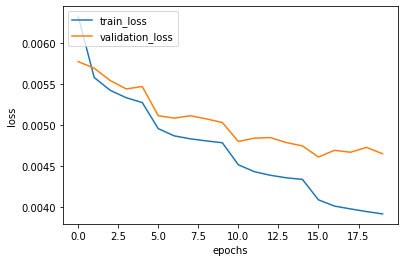

In [0]:
from matplotlib import pyplot as plt
plt.ion()
plt.figure()
plt.plot(train_loss[:20],label='train_loss')
plt.plot(val_loss[:20],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.savefig("./hidden_l.jpg")

In [0]:
plt.savefig("./loss.jpg")

<Figure size 432x288 with 0 Axes>